In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime

import os
import pendulum
import scipy
import scikit_posthocs as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

# Load Statsmodels 
import statsmodels.api as sm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# Configure Pandas to display all columns and rows
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)

# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Load final data

In [175]:
df = pd.read_csv('data/df_final.csv')

In [176]:
df.head()

,PRODUCT_KEY,GEOGRAPHY_KEY,TIME_KEY,UNIT_SALES,DOLLAR_SALES,VOLUME_SALES,WEEKLY_DATE,GEOGRAPHY_KEY.1,GEOGRAPHY_DESCRIPTION,WHOLESALER_ID_VALUE,RETAILER_NAME,CITY,STATE_CODE,ZIP_CODE,OUTLET_NAME,PRODUCT_KEY.1,PRODUCT_DESCRIPTION,AB_CATEGORY_STYLE_VALUE,AB_WAMP_VALUE,BEER_STYLE_VALUE,BRAND_VALUE,BREWER_VALUE,TYPE_VALUE
0,210280222,39774,2051,15.00,29.85,1.30,2018-12-23,39774,"RITE AID PHARMACY 568 : 50 S MAIN ST, JAMESTOW...",3142,RITE AID - RITE AID PHARMACY,JAMESTOWN,NY,14701,DRUG,210280222,**********,CLASSIC LAGER,CORE,AMERICAN LAGER,**********,ANHEUSER-BUSCH INBEV,BEER
1,210281267,39774,2051,36.00,71.64,3.10,2018-12-23,39774,"RITE AID PHARMACY 568 : 50 S MAIN ST, JAMESTOW...",3142,RITE AID - RITE AID PHARMACY,JAMESTOWN,NY,14701,DRUG,210281267,**********,EASY DRINKING,CORE,AMERICAN LAGER,**********,ANHEUSER-BUSCH INBEV,BEER
2,210283096,5446689,2051,296.00,298.32,25.70,2018-12-23,5446689,"SPEEDWAY SUPERAMERICA 7877 : 2121 FOREST AVE, ...",43100,7 ELEVEN - SPEEDWAY SUPERAMERICA,STATEN ISLAND,NY,10303,CONVENIENCE,210283096,**********,CLASSIC LAGER,VALUE,AMERICAN LAGER,**********,ANHEUSER-BUSCH INBEV,BEER
3,210280222,627036,2051,35.00,71.21,3.00,2018-12-23,627036,7 ELEVEN/NORTH ATLANTIC DIV 35205 : 518 N MAIN...,3142,7-ELEVEN - 7 ELEVEN/NORTH ATLANTIC DIV,JAMESTOWN,NY,14701,CONVENIENCE,210280222,**********,CLASSIC LAGER,CORE,AMERICAN LAGER,**********,ANHEUSER-BUSCH INBEV,BEER
4,210283096,147449,2051,85.00,126.65,7.40,2018-12-23,147449,"K MART 7749 : 250 W 34TH ST, NEW YORK, NY",43100,KMART - K MART,NEW YORK,NY,10119,MASS MERCHANDISER,210283096,**********,CLASSIC LAGER,VALUE,AMERICAN LAGER,**********,ANHEUSER-BUSCH INBEV,BEER


## Explore data

In [180]:
df.shape

(16357, 23)

In [181]:
# Data types of the columns

df.dtypes

product_key                  int64
geography_key                int64
time_key                     int64
unit_sales                 float64
dollar_sales               float64
volume_sales               float64
weekly_date                 object
geography_key.1              int64
geography_description       object
wholesaler_id_value          int64
retailer_name               object
city                        object
state_code                  object
zip_code                     int64
outlet_name                 object
product_key.1                int64
product_description         object
ab_category_style_value     object
ab_wamp_value               object
beer_style_value            object
brand_value                 object
brewer_value                object
type_value                  object
dtype: object

In [182]:
# conver the date col to datetime
df['dates'] = pd.to_datetime(df['weekly_date'])

df.dtypes

product_key                         int64
geography_key                       int64
time_key                            int64
unit_sales                        float64
dollar_sales                      float64
volume_sales                      float64
weekly_date                        object
geography_key.1                     int64
geography_description              object
wholesaler_id_value                 int64
retailer_name                      object
city                               object
state_code                         object
zip_code                            int64
outlet_name                        object
product_key.1                       int64
product_description                object
ab_category_style_value            object
ab_wamp_value                      object
beer_style_value                   object
brand_value                        object
brewer_value                       object
type_value                         object
dates                      datetim

## Generate ACF and PACF plots

#### Few feature engineering approaches to experiment with - 

- **Lagged features for the target variable**
- **Rolling window feature.**

### For lagged features - plot ACF plots and PACF plots

- `ACF plots helps to understand the correlation between time series and the lagged version of itself.`
- `PACF plots helps to understand the correlation between the time series with a lagged version of itself but after    eliminating the variations already explained by the intervening comparisons.`

Text(0.5, 1.0, 'PACF plot for unit_sales')

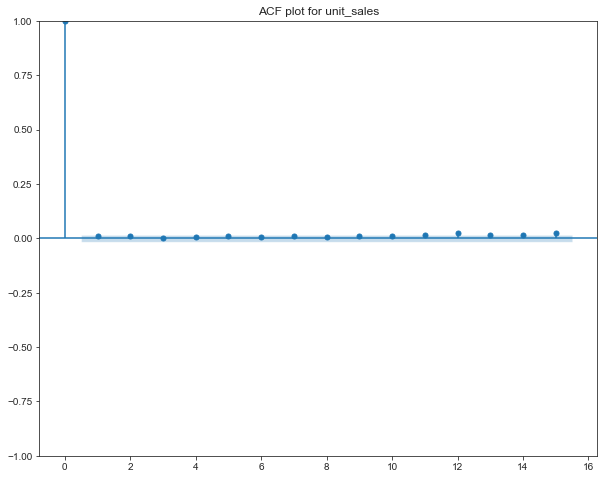

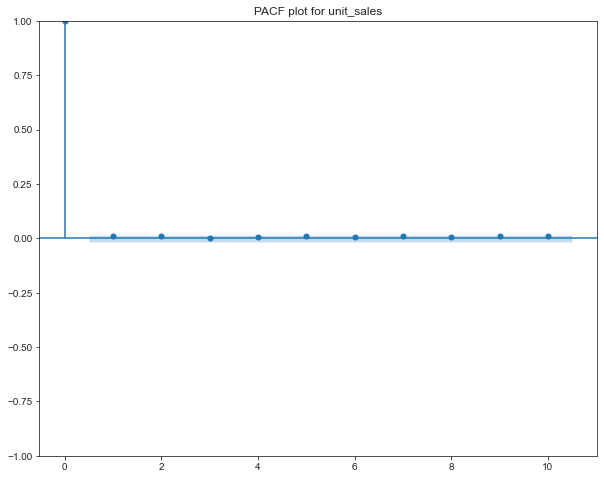

In [219]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

       
plot_acf(df['unit_sales'], lags=15)
plt.title('ACF plot for unit_sales')

plot_pacf(df['unit_sales'], lags=10, method='ols')
plt.title('PACF plot for unit_sales')

- **`There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random and is not white noise.`** <br>
- **`High degree of autocorrelation between adjacent (lag = 2) and near-adjacent (lag = 5) observations in PACF plot`**
- **`High degree of autocorrelation between several adjacent lag observations in ACF plot.`**

## Feature Engineering

## Considering the autocorrelations based on ACF  & PACF plots - Create lagged features

In [147]:
def get_lagged_features(df, col):
    
    df_lagged = df.copy()
      
    df_lagged[f'{col}_lag_2'] = df_lagged[col].shift(2)
    df_lagged[f'{col}_lag_5'] = df_lagged[col].shift(5)    

    df_lagged = df_lagged.fillna(method='bfill')
    
    return df_lagged

df_lagged = get_lagged_features(df, 'unit_sales')
df_lagged.shape

(2534, 25)

## Create rolling window features

In [148]:
def get_rolling_window_features(df, col):
    
    df_rolling_window = df.copy()
      
    df_rolling_window[f'{col}_rolling_mean'] = df_rolling_window[col].rolling(window=8).mean()
    df_rolling_window = df_rolling_window.fillna(method='bfill')
    
    return df_rolling_window

df_rolling_window = get_rolling_window_features(df_lagged, 'unit_sales')
df_rolling_window.shape

(2534, 26)

In [149]:
df_rolling_window.head()

,dates,wholesaler_id_value,state_code,retailer_name,outlet_name,product_key,ab_category_style_value,ab_wamp_value,beer_style_value,brewer_value,type_value,unit_sales,dollar_sales,volume_sales,year,month,day,week,season,holiday,product_price,relative_beer_style_price,beer_style_mean_price,unit_sales_lag_2,unit_sales_lag_5,unit_sales_rolling_mean
0,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1412422,EASY DRINKING,PREMIUM,TROPICAL LAGER,CONSTELLATION BRANDS,BEER,22.00,318.78,11.00,2018,12,23,51,winter,0,14.49,0.97,14.96,22.00,22.00,30.50
1,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,609521221,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,32.00,479.68,16.00,2018,12,23,51,winter,0,14.99,1.00,15.04,22.00,22.00,30.50
2,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,1321133691,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,BOSTON BEER CO,MALT BEVERAGE,33.00,494.67,16.50,2018,12,23,51,winter,0,14.99,1.00,15.04,22.00,22.00,30.50
3,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,659550424,HARD BEVERAGES (BEER),BEYOND BEER,VARIETY PACK/SAMPLER,MARK ANTHONY BRANDS INC,MALT BEVERAGE,30.00,448.70,15.00,2018,12,23,51,winter,0,14.96,0.99,15.04,32.00,22.00,30.50
4,2018-12-23,33107,NY,WEGMANS - WEGMANS,GROCERY,262793636,CRAFT & STYLES,PREMIUM,IPA,FOUNDERS BREWING CO,BEER,22.00,373.78,13.80,2018,12,23,51,winter,0,16.99,0.99,17.22,33.00,22.00,30.50


## Statistical test to check stationarity in time series 

**We will experiment with `Augmented Dickey-Fuller (ADF)`**

**Null Hypothesis (HO): Series is non-stationary.**

**Alternate Hypothesis(HA): Series is stationary.**

In [220]:
# Changing the YEAR data type and setting it as index
df_copy = df.copy()
df_copy.index = df_copy['dates']

del df_copy['dates']

# ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

# Run test
adf_test(df_copy['unit_sales'])


Results of Dickey-Fuller Test:
Test Statistic                   -12.15
p-value                            0.00
#Lags Used                        43.00
Number of Observations Used   16,313.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64


**The p-value is significant and hence, we can reject the null hypothesis and as expected, declare that the time series is infact stationary which is an assumption for the time series models.**

## Run statistical tests to understand impact of features on power consumption

**Run ANOVA, Kruskal-Wallis and post hoc tests for the categorical features to understand if the group means are statistically significant.**

In [221]:
anova_args = tuple(df.groupby('beer_style_value')['unit_sales'].apply(list).reset_index()['unit_sales'])
f_statistic, p_value = scipy.stats.f_oneway(*anova_args)

print(f_statistic, p_value)

600.1916825776608 0.0


In [222]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df['unit_sales'], groups=df['beer_style_value'], alpha=0.05)
print(m_comp)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
    group1            group2         meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------------------
AMERICAN LAGER                  IPA  -93.2781  0.001  -105.802  -80.7542   True
AMERICAN LAGER          MALT LIQUOR   82.6907  0.001    70.366   95.0154   True
AMERICAN LAGER       TROPICAL LAGER  -82.8779  0.001  -91.8377  -73.9181   True
AMERICAN LAGER VARIETY PACK/SAMPLER  -88.4446  0.001   -95.599  -81.2902   True
           IPA          MALT LIQUOR  175.9688  0.001  159.7559  192.1818   True
           IPA       TROPICAL LAGER   10.4002 0.2414   -3.4288   24.2292  False
           IPA VARIETY PACK/SAMPLER    4.8336 0.8177   -7.9001   17.5673  False
   MALT LIQUOR       TROPICAL LAGER -165.5686  0.001 -179.2174 -151.9198   True
   MALT LIQUOR VARIETY PACK/SAMPLER -171.1353  0.001 -183.6731 -158.5975   True
TROPICAL LAGER VARIETY PACK/SAMPLER   -5

**Running the ANOVA test on the weekdays column to understand if the each of the weekday category mean power consumption is statistically different from each other. And with a small p-value, it does seem like that is the case.** 

**Running a pairwise post hoc test to understand the differences in pairs of the groups in weekdays - looks like except (Friday, Monday), (Thursday, Tuesday), (Thursday, Wednesday) & (Tuesday, Wednesday) - all the other pairs seem to have statistically significantly different group means.**

In [223]:
kruskal_args = tuple(df.groupby('holiday')['unit_sales'].apply(list).reset_index()['unit_sales'])
h_statistic, p_value = scipy.stats.kruskal(*kruskal_args)
print(p_value)

0.8123813128063446


In [224]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df['unit_sales'], groups=df['holiday'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   -2.398 0.4194 -8.2186 3.4227  False
---------------------------------------------------


**Running the Kruskal-wallis test on the non_working column to understand if the two categories have their difference in mean power consumption statistically significant from each other. And with a small p-value, it does seem like that is the case.** 

## Fill in missing data in individual time series where a wholesaler did not have any sales for the products

- `Assumption - All wholesalers get all of the chosen 10 products but there could be few wholesalers with no sales for certain products. We will remove time series where a wholesaler did not sell a particular product even once in the last 5 years.`

In [195]:
unique_wholesalers = list(df.wholesaler_id_value.unique())
unique_products = list(df.product_key.unique())

In [198]:
for w in unique_wholesalers:
    for p in unique_products:
        df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
        print(f'For wholesaler {w} & product {p} time series, there are {df_small.shape[0]} weeks in the data')

For wholesaler 3142 & product 210280222 time series, there are 520 weeks in the data
For wholesaler 3142 & product 210281267 time series, there are 518 weeks in the data
For wholesaler 3142 & product 210283096 time series, there are 524 weeks in the data
For wholesaler 3142 & product 210284670 time series, there are 417 weeks in the data
For wholesaler 3142 & product 1412422 time series, there are 514 weeks in the data
For wholesaler 3142 & product 210281273 time series, there are 526 weeks in the data
For wholesaler 3142 & product 659550424 time series, there are 403 weeks in the data
For wholesaler 3142 & product 262793636 time series, there are 118 weeks in the data
For wholesaler 3142 & product 609521221 time series, there are 173 weeks in the data
For wholesaler 3142 & product 1321133691 time series, there are 298 weeks in the data
For wholesaler 43100 & product 210280222 time series, there are 321 weeks in the data
For wholesaler 43100 & product 210281267 time series, there are 9

In [199]:
revised_df_list = []

for w in unique_wholesalers:
    for p in unique_products:
        
        df_small = df[(df['wholesaler_id_value']== w) & (df['product_key']== p)]
        
        new_df = pd.DataFrame()
        new_df['revised_dates'] = pd.date_range(start='2018-01-07', end='2023-01-15', freq='W')
        
        new_df['wholesaler_id_value'] = w
        new_df['product_key'] = p
    
        df_small = df_small[['dates', 'wholesaler_id_value', 'product_key',
                             'unit_sales', 'dollar_sales', 'volume_sales']]
        
        new_df = new_df.merge(df_small, how='left', left_on='revised_dates', right_on='dates')
        new_df.drop(['wholesaler_id_value_y', 'product_key_y'], axis=1, inplace=True)
        
        revised_df_list.append(new_df)
        
revised_df = pd.concat(revised_df_list)
revised_df['unit_sales'] = revised_df['unit_sales'].fillna(0)
revised_df['dollar_sales'] = revised_df['unit_sales'].fillna(0)
revised_df['volume_sales'] = revised_df['unit_sales'].fillna(0)


revised_df.isnull().sum()

revised_dates               0
wholesaler_id_value_x       0
product_key_x               0
dates                    8039
unit_sales                  0
dollar_sales                0
volume_sales                0
dtype: int64

In [200]:
revised_df.shape

(24396, 7)

In [201]:
revised_df.head()

,revised_dates,wholesaler_id_value_x,product_key_x,dates,unit_sales,dollar_sales,volume_sales
0,2018-01-07,3142,210280222,2018-01-07,54.00,54.00,54.00
1,2018-01-07,3142,210280222,2018-01-07,9.00,9.00,9.00
2,2018-01-14,3142,210280222,2018-01-14,62.00,62.00,62.00
3,2018-01-14,3142,210280222,2018-01-14,2.00,2.00,2.00
4,2018-01-21,3142,210280222,2018-01-21,59.00,59.00,59.00


## Save the final data

In [154]:
df_with_features = df_rolling_window.copy()
df_with_features.to_csv('data/beer_data_with_features.csv', index=False)